In [9]:
from bs4 import BeautifulSoup
import requests,re, matplotlib.pyplot as plt
from itertools import count

In [10]:
Warsaw = True
Krakow = False

### Pełna oferta

In [11]:
class Offer:
    iterator =(count(start = 1, step = 1))
    def __init__(self,title,link,price):
        self.id = next(self.iterator)
        self.title = title
        self.price = price
        self.link = 'https://www.gumtree.pl' + link
        if Warsaw:
            district_name_regex = 'wynajecia\/\w+'
            tmp = re.search(district_name_regex,self.link).group(0)
            district_name_regex2 = '\/\w+'
            # [1:]pozbywam sie '/' na poczatku 
            self.district = re.search(district_name_regex2,tmp).group(0)[1:]

        self.get_more_info()

    def __str__(self):
        return f'{self.id}. {self.title} {self.price}'
    #web scrap na trochę większą skalę 
    def get_more_info(self):
        response = requests.get(self.link)
        soup = BeautifulSoup(response.text, 'html.parser')
        other_info = [x.text for x in soup.find_all('div',{'class':'attribute'})]
        

        for i in range(len(other_info)):
            if 'Data dodania' in other_info[i]:
                # other_info[0] "Data dodania13/10/2021"
                date_regex = "\d{1,2}\/\d{1,2}\/\d{4}"
                self.date_added = re.search(date_regex,other_info[i]).group(0)

            if "Do wynajęcia przez" in other_info[i]:
                # other_info[2] 'Do wynajęcia przezWłaściciel'
                if 'Właściciel' in other_info[i]:
                    self.owner = 'Właściciel'
                else:
                    self.owner = 'Agencja'

            if "Dostępny" in other_info[i]:
                # other_info[3]'Dostępny od2021-11-03',
                date_regex2 = r"\d{4}\-\d{1,2}\-\d{1,2}"
                if re.search(date_regex2,other_info[i]) is not None:
                    self.access_date = re.search(date_regex2,other_info[i]).group(0)
                else:
                    self.access_date = 'brak'

            if "Rodzaj nieruchomości" in other_info[i]:
                # other_info[4] 'Rodzaj nieruchomościMieszkanie'
                if 'Mieszkanie' in other_info[i]:
                    self.property_type = 'Mieszkanie'
                elif 'Dom' in other_info[i]:
                    self.property_type = 'Dom'
                else :
                    self.property_type = 'Inne'


            # other_info[5] 'Liczba pokoi2 pokoje'
            if 'Liczba pokoi' in other_info[i]:
                room_regex = "\d+"

                if re.search(room_regex,other_info[i]) is not None:
                    self.room_count = re.search(room_regex,other_info[i]).group(0)
                elif "Kawalerka" in other_info[i]:
                    self.room_count = "Kawalerka"
                else:
                    self.room_count = 'brak'

            # other_info[6] 'Liczba łazienek1 łazienka',
            if 'Liczba łazienek' in other_info[i]:
                bathroom_regex="\d+"

                if re.search(bathroom_regex,other_info[i]) is not None:
                    self.bathroom_count = re.search(bathroom_regex,other_info[i]).group(0)
                else:
                    self.bathroom_count = 'brak'

            # other_info[7] 'Wielkość (m2)54'
            if "Wielkość" in other_info[i]:
                living_space_regex = "\d{2,3}"
                if re.search(living_space_regex,other_info[i]) is not None:
                    self.living_space = re.search(living_space_regex,other_info[i]).group(0)
                else:
                    self.living_space = 'brak'

            # other_info[8] 'PalącyNie'
            if "Palący" in other_info[i]:
                if len(other_info) == 9:
                    if 'Tak' in other_info[-1]:
                        self.smoker = 'Tak'
                    else:
                        self.smoker = 'Nie'
    


In [12]:
class Offers:
    def __init__(self,title):
        self.offers = {}
        self.title = title

    def add_offer(self,offer):
        assert type(offer) == Offer
        self.offers[offer.id] = offer

### Wydobywanie pożądanych informacji z tekstu


In [13]:
def extract_prices(regex,re_Match_objects_list):
    '''
            Temporary function. Need upgrade.
    
    input: regex -> dany wzorzec do wyszukiwaania 

        re_Match_objects_list -> lista stringów 

    output: lista zawierająca wszystkie wzorce wyszukane w stringu
    
    '''
    tmp =[]
    for single_element in re_Match_objects_list:
        # re.search -> Scan through string looking for a match to the pattern, returning a Match object, or None if no match was found.
        single_element =re.search(regex, str(single_element))
        try:
            # group(0) returns the full string matched by the regex
            single_element = single_element.group(0)
        except (TypeError,AttributeError):
            single_element = '000'
        # funkcja zbudowana pod konkretny przpypadek - nie jest uniwersalna!
        single_element = "".join(single_element[0:-2].split())   
        tmp.append(int(single_element))
    return tmp

def displaymatch(match):
    if match is None:
        return None
    return ('%r') % (match.group(0))

In [14]:
# https://regexr.com/
prices_regex = "\d*\s{1}\d+\szł"
gumtree_offers = Offers("Oferty z gumtree")

### Web scrap na przykładzie gumtree

In [15]:
for page_number in range(2,5):
    if Krakow:
        html_text = requests.get(f"https://www.gumtree.pl/s-mieszkania-i-domy-do-wynajecia/krakow/page-{page_number}/v1c9008l3200208p{page_number}")
    if Warsaw:
        html_text = requests.get(f"https://www.gumtree.pl/s-mieszkania-i-domy-do-wynajecia/warszawa/page-{page_number}/v1c9008l3200008p{page_number}")
    assert html_text.status_code == 200

    soup = BeautifulSoup(html_text.text, 'lxml')
    offers = soup.find_all('div',class_ = 'tileV1')

    links_2 = soup.find_all('a',class_='href-link tile-title-text', href=True)
    links_2 = [x['href'] for x in links_2]
    links =[offers[x].find('a',class_='href-link tile-title-text') for x in range(0,len(offers))] 

    titles = [x.text for x in links]

    prices = [offers[x].find('span',class_='ad-price') for x in range(0,len(offers))]
    prices = extract_prices(prices_regex,prices)


    assert len(offers)==len(prices)

    # print([displaymatch(match) for match in tmp])

    for i in range(len(offers)):
        gumtree_offers.add_offer(Offer(titles[i],links_2[i],prices[i]))

FeatureNotFound: Couldn't find a tree builder with the features you requested: lxml. Do you need to install a parser library?

In [ ]:
print(len(gumtree_offers.offers))


gumtree_offers.offers[1].price

69


2300

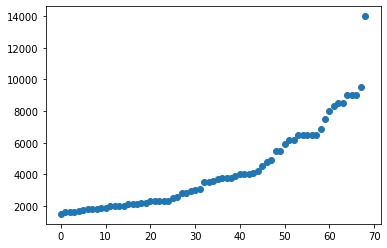

In [ ]:
prices = [x.price for x in gumtree_offers.offers.values()
if x.price != 0 and x.price < 100000]
plt.scatter(range(len(prices)),sorted(prices))
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x242409609d0>,
 'caps': [<matplotlib.lines.Line2D at 0x24240960250>,
 'boxes': [<matplotlib.lines.Line2D at 0x24240960e20>],
 'medians': [<matplotlib.lines.Line2D at 0x24240965370>],
 'fliers': [<matplotlib.lines.Line2D at 0x24240965940>],
 'means': []}

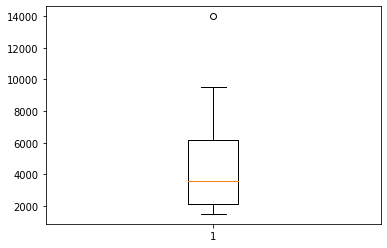

In [ ]:

plt.boxplot(prices)

{'whiskers': [<matplotlib.lines.Line2D at 0x24240a5e130>,
 'caps': [<matplotlib.lines.Line2D at 0x242408ae460>,
 'boxes': [<matplotlib.lines.Line2D at 0x24240a5e4f0>],
 'medians': [<matplotlib.lines.Line2D at 0x242408aea00>],
 'fliers': [<matplotlib.lines.Line2D at 0x24240a0eac0>],
 'means': []}

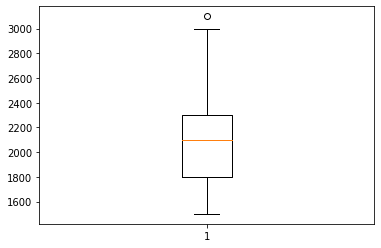

In [ ]:
prices2 = [x for x in prices if x < 3500]
plt.boxplot(prices2)

In [ ]:
links = [x.link for x in gumtree_offers.offers.values()]
links[1:5]

['https://www.gumtree.pl/a-mieszkania-i-domy-do-wynajecia/wola/bezposrednio-lux+-do-wynajecia-2-pok-58-m-warszawa-wola-okopowa-56/10010072620221010845082409',
 'https://www.gumtree.pl/a-mieszkania-i-domy-do-wynajecia/wola/mieszkanie-2-pok-warszawa-zelazna-2+room-flat/10010087566721010501420309',
 'https://www.gumtree.pl/a-mieszkania-i-domy-do-wynajecia/mokotow/mokotow+belwederska-+48m+3-pokoje+balkon+-po-remoncie/10010015658361010470678209',
 'https://www.gumtree.pl/a-mieszkania-i-domy-do-wynajecia/targowek/nowe-2pok-50m-+targowek-ul-uznamska+garaz+ciche+balkon/10010161783141012853461509']

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
type(gumtree_offers.offers[1])
# dir(gumtree_offers.offers[1])

__main__.Offer

In [ ]:
for property, value in vars(gumtree_offers.offers[5]).items():
    print(property, ":", value)


id : 5
title : Nowe 2pok(50m)-Targówek, ul.Uznamska-garaż-ciche-balkon
price : 2100
link : https://www.gumtree.pl/a-mieszkania-i-domy-do-wynajecia/targowek/nowe-2pok-50m-+targowek-ul-uznamska+garaz+ciche+balkon/10010161783141012853461509
district : targowek
date_added : 17/11/2021
owner : Agencja
property_type : Mieszkanie
room_count : 2
living_space : 50


['access_date',
'bathroom_count',
'date_added',
'get_more_info',
'id',
'iterator',
'link',
'living_space',
'owner',
'price',
'property_type',
'room_count',
'title']

In [ ]:
d = {
'id': [x.id if hasattr(x, 'id') else np.nan for x in gumtree_offers.offers.values()],
'district': [x.district  if hasattr(x, 'district') else np.nan for x in gumtree_offers.offers.values()],
'living_space': [int(x.living_space) if hasattr(x, 'living_space') else np.nan for x in gumtree_offers.offers.values()],
'price': [x.price if hasattr(x, 'price') else np.nan for x in gumtree_offers.offers.values()],
'room_count': [x.room_count if hasattr(x, 'room_count') else np.nan for x in gumtree_offers.offers.values()],
'access_date': [x.access_date  if hasattr(x, 'access_date') else np.nan for x in gumtree_offers.offers.values()],
'bathroom_count': [int(x.bathroom_count) if hasattr(x, 'bathroom_count') else np.nan for x in gumtree_offers.offers.values()],
'date_added': [x.date_added if hasattr(x, 'date_added') else np.nan for x in gumtree_offers.offers.values()],
'owner': [x.owner if hasattr(x, 'owner') else np.nan for x in gumtree_offers.offers.values()],
'property_type': [x.property_type if hasattr(x, 'property_type') else np.nan for x in gumtree_offers.offers.values()],
'room_count': [x.room_count if hasattr(x, 'room_count') else np.nan for x in gumtree_offers.offers.values()],
'link': [x.link if hasattr(x, 'link') else np.nan for x in gumtree_offers.offers.values()],
'smoker': [x.smoker if hasattr(x, 'smoker') else np.nan for x in gumtree_offers.offers.values()],
'title': [x.title if hasattr(x, 'title') else np.nan for x in gumtree_offers.offers.values()]}
df = pd.DataFrame(data=d).sort_values(by=['district'])
# df["district"].value_counts()
df.head()


,id,district,living_space,price,room_count,access_date,bathroom_count,date_added,owner,property_type,link,smoker,title
15,16,bemowo,37,2300,2,NaN,1.0,17/11/2021,Agencja,Mieszkanie,https://www.gumtree.pl/a-mieszkania-i-domy-do-...,NaN,"Mieszkanie 37m2, ul.Szeligowska, Bemowo"
13,14,bemowo,50,2300,2,2021-11-16,1.0,16/11/2021,Agencja,Mieszkanie,https://www.gumtree.pl/a-mieszkania-i-domy-do-...,NaN,"2 pok, 50m2 - ul. Pełczyńskiego / Lazurowa / B..."
5,6,bialoleka,55,1800,2,NaN,NaN,17/11/2021,Agencja,Mieszkanie,https://www.gumtree.pl/a-mieszkania-i-domy-do-...,NaN,Nowe-2pok-55m-Marcina z Wrocimowic-2 balkony-T...
20,21,bielany,30,1800,Kawalerka,2021-12-01,1.0,19/10/2021,Agencja,Mieszkanie,https://www.gumtree.pl/a-mieszkania-i-domy-do-...,NaN,Do wynajęcia od zaraz komfortowa kawalerka 30m2 !
66,67,mokotow,165,6900,4,NaN,NaN,17/11/2021,Agencja,Mieszkanie,https://www.gumtree.pl/a-mieszkania-i-domy-do-...,NaN,Mieszkanie Warszawa Mokotów 165m2 (nr: 5741)


In [ ]:
# df.to_csv('gumtree_offers.csv',index=True, encoding='utf-8-sig')

In [ ]:
pd.isna(df).sum()
df["living_space"].fillna(df["living_space"].mean(), inplace=True)

id                 0
district           0
living_space       0
price              0
room_count         0
access_date       49
bathroom_count    41
date_added         0
owner              0
property_type      0
link               0
smoker            69
title              0
dtype: int64

In [ ]:
df = df[df["price"]<12000]

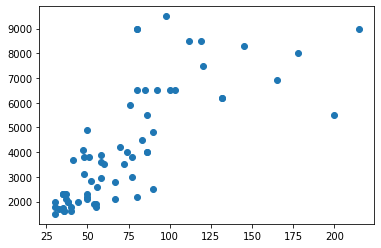

In [ ]:
plt.scatter(df["living_space"],df["price"])

In [ ]:
#  // linear reggression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


model = LinearRegression()
model.fit(df[["living_space"]],df["price"])
y_pred = model.predict(df[["living_space"]])
print("Coefficients: \n", model.coef_)
# The mean squared error




Coefficients: 
 [43.8735299]


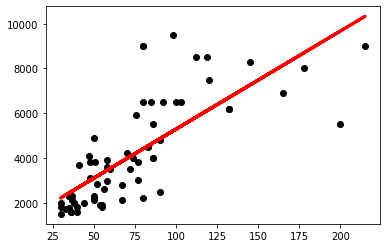

In [ ]:
plt.scatter(df[["living_space"]],df["price"], color="black")
plt.plot(df[["living_space"]], y_pred, color="red", linewidth=3)

# plt.xticks(())
# plt.yticks(())

plt.show()

In [ ]:
df["room_count"].replace(['brak',np.nan],0,inplace=True)
df["room_count"].replace('Kawalerka',1,inplace=True)
df["bathroom_count"].fillna(1, inplace=True)
df["room_count"] = df["room_count"].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 15 to 0
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              68 non-null     int64  
 1   district        68 non-null     object 
 2   living_space    68 non-null     int64  
 3   price           68 non-null     int64  
 4   room_count      68 non-null     int32  
 5   access_date     20 non-null     object 
 6   bathroom_count  68 non-null     float64
 7   date_added      68 non-null     object 
 8   owner           68 non-null     object 
 9   property_type   68 non-null     object 
 10  link            68 non-null     object 
 11  smoker          0 non-null      float64
 12  title           68 non-null     object 
dtypes: float64(2), int32(1), int64(3), object(7)
memory usage: 7.2+ KB


In [ ]:
regr_cols = ['living_space','bathroom_count','room_count']
pd.isna(df).sum()
# df = pd.read_csv('gumtree_offers.csv')


id                 0
district           0
living_space       0
price              0
room_count         0
access_date       48
bathroom_count     0
date_added         0
owner              0
property_type      0
link               0
smoker            68
title              0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[regr_cols], df["price"], test_size=0.2, random_state=0)
model2 = LinearRegression()
model2.fit(x_train,y_train)
y_pred2 = model2.predict(x_test)
model2.score(x_train, y_train   )


0.6128880599063772

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 15 to 0
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              68 non-null     int64  
 1   district        68 non-null     object 
 2   living_space    68 non-null     int64  
 3   price           68 non-null     int64  
 4   room_count      68 non-null     int32  
 5   access_date     20 non-null     object 
 6   bathroom_count  68 non-null     float64
 7   date_added      68 non-null     object 
 8   owner           68 non-null     object 
 9   property_type   68 non-null     object 
 10  link            68 non-null     object 
 11  smoker          0 non-null      float64
 12  title           68 non-null     object 
dtypes: float64(2), int32(1), int64(3), object(7)
memory usage: 7.2+ KB
